# imports and setup


In [11]:
import sys
from datetime import datetime
from copy import deepcopy

from catppuccin.extras.rich_ctp import mocha
from rich import pretty
from rich.console import Console
from rich.pretty import pprint

pretty.install()

if ".." not in sys.path:
    sys.path.insert(0, "..")

from src.config.settings import get_settings
from src.utils.logger import create_logger, ChatPrinter

console = Console(theme=mocha)
settings = get_settings()
logger = create_logger(path=settings.paths.logs_dir)
printer = ChatPrinter()
logger.debug(f"settings loaded as \n{settings.model_dump_json(indent=2)}")

10:15 AM | 618548893 .L:22  | DEBUG     | settings loaded as 
{
  "models": {
    "hf": {
      "chat": "meta-llama/Llama-3.2-3B-Instruct:together",
      "reasoning": "zai-org/GLM-4.7-Flash:novita",
      "structured_output": "Qwen/Qwen3-Coder-30B-A3B-Instruct:ovhcloud",
      "embedding_snowflake": "Snowflake/snowflake-arctic-embed-l-v2.0",
      "embedding_specter": "allenai/specter2_base",
      "encoder": "m3rg-iitd/matscibert",
      "reranker": "Qwen/Qwen3-Reranker-0.6B",
      "router": "openai/gpt-oss-20b:together"
    },
    "nebius": {
      "reasoning": "deepseek-ai/DeepSeek-V3.2",
      "tool_user": "Qwen/Qwen3-30B-A3B-Instruct-2507",
      "chat": "meta-llama/Meta-Llama-3.1-8B-Instruct-fast",
      "embedding_baai_bge": "BAAI/bge-multilingual-gemma2",
      "router": "openai/gpt-oss-20b"
    }
  },
  "paths": {
    "base_dir": "/home/rudy/code/lattice/src",
    "data_dir": "/home/rudy/code/lattice/src/data",
    "logs_dir": "/home/rudy/code/lattice/src/logs",
    "agents_

In [2]:
from typing import Annotated, Dict, List, Optional, TypedDict, Literal

from langchain_core.messages import (
    AIMessage,
    HumanMessage,
    AIMessageChunk,
    MessageLikeRepresentation,
    SystemMessage,
    ToolMessage,
    filter_messages,
    get_buffer_string,
    convert_to_openai_messages,
)
from langchain_core.tools import tool
from langchain_core.utils.function_calling import convert_to_openai_tool
from langchain_openai import ChatOpenAI
from langchain_nebius import ChatNebius
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import END, START, StateGraph, MessagesState
from langgraph.prebuilt import ToolNode
from langgraph.graph.message import add_messages
from langgraph.types import Command, interrupt
from pydantic import BaseModel, Field, create_model
from pydantic.json_schema import SkipJsonSchema

In [3]:
from src.backends.virtual_filesystem import VirtualFilesystem
from src.prompts import (
    ask_mode_system_prompt,
    planning_mode_systemm_prompt,
    planning_structured_output,
)
from src.schemas import RESEARCH_PLAN_TEMPLATE, ResearchPlan
from src.schemas.prompts import SystemPromptTemplate
from src.tools.filesystem import create_filesystem_tools
from src.tools.thinking import (
    think_tool,
    switch_to_ask_mode_tool,
    switch_to_planning_mode_tool,
    switch_to_execution_mode_tool,
)
from src.tools.utils import wrap_tool_with_doc_and_error_handling, SkipSchema
from src.utils.stats import accumulate_usage, add_usage_metadata

version = "0.0.1-alpha"

In [4]:
filesystem_tools = create_filesystem_tools(VirtualFilesystem())

# state


In [14]:
class TodoItems(TypedDict):
    content: str
    subitems: List[str]


class AgentState(TypedDict):
    # list of messages
    messages: Annotated[List[MessageLikeRepresentation], add_messages]
    # current mode
    mode: Literal["ask", "planning", "execution"] = "ask"
    # whatever the agent needs across all the modes
    todo: List[TodoItems]
    research_plan: str | ResearchPlan
    plan_approval_status: Literal["pending", "rejected", "approved"]
    # thoughts
    thoughts: List[str]

# LLM


In [6]:
chat_llm = ChatOpenAI(
    model=settings.models.nebius.tool_user,
    api_key=settings.env.NEBIUS_API_KEY,
    base_url=settings.env.NEBIUS_API_ENDPOINT,
    max_completion_tokens=8192,
    temperature=0.0,
    top_p=0.7,
    streaming=True,
)

# Graph


naming conventions:
- router funcs end with `_router`
- node funcs end with `_node`
- tool funcs contain `tool`
- mode funcs contain the mode name

## prompts

In [29]:
ask_mode_system_prompt.workflow = """Given a user query, broadly follow the below steps:
1. Judge if the query is complex. 
    a. Look at the conversation history to understand if the current context of the conversation is complex or straightforward.
    b. Straightforward queries are usually like:
        - small talk (eg: "how are you?", "how can you help me?" etc)
        - basic questions (eg: simple arithmetic, questions about universal facts etc)
2. if the query is deemed to be straightforward, then answer the question directly.
3. if the query is deemed complex, 
    a. use the `think_tool` to think and reflect. 
    b. for each thought, make a single call for `think_tool`
    c. if you think you need some input from the user, do not use any tool and just send your response.
    d. if you are unsure about anything, just ask the user.
    e. based on new user input evaluate the current conversation context and proceed from step 2.
4. once you deem the user has presented you with a query asking for help with their research literature survey and you have fulfilled all criteria to use the `switch_to_planning_mode_tool`, use it and proceed to the next mode.
"""
ask_mode_system_prompt.tools = tools = """You have access to the following tools:
-   tool name:`think_tool`
    when and how to use: Use this tool to reflect and think strategically. Use your reflections to refine your next course of action. You should pass exactly one thought to this tool at a single time. To maintain a clear line of reasoning, your thought should be short and at maximum 2 - 3 simple sentences only. If you are reviewing your past thoughts with this tool, then make sure to critique your past thoughts. You should ideally think about:
        - what information you need to answer the user's question
        - if you have those information available
        - if you need more information, how should you collect it
        - once you have all information, how should you respond
        - what follow up's can the user come up with
        - how can you tackle those follow up's
    
-   tool name: `switch_to_planning_mode_tool`
    when and how to use: use this tool when you want to switch modes to PLANNING from ASK. Here is a simple flowchart to follow if you want to decide whether to use this tool:
    - has the user explicitly requested to move to planning? if yes, switch to planning.
    - have you gathered all the clarifications and informations you needed from the user to help with their research survey? if yes, switch to planning. otherwise stay in your current mode.
    - is the user asking just general questions? if yes, stay in your current mode.
    - if your current response would have been anything like "I am ready to draft the research plan", use this tool to switch mode.
    If you are unsure about anything at any point, feel free to use the `think_tool` to think and reflect or just ask the user. 
"""

In [30]:
def mode_router(state: AgentState) -> Literal["ask", "planning", "execution"]:
    current_mode = state.get("mode", "ask")
    printer.debug(f"Routing from start to {current_mode}")
    return current_mode


def ask_node(state: AgentState) -> AgentState | Dict:
    # we need to serve the context to the ask node
    # it contains
    # - system prompt
    # - all non tool messages messages with non-empty content
    # - all tool messages except the ones from `think_tool`
    # - thoughts
    system_prompt = [SystemMessage(ask_mode_system_prompt.to_markdown())]
    messages = [
        _
        for _ in state["messages"]
        if (len(_.content) > 0 and not isinstance(_, ToolMessage))
        or (isinstance(_, ToolMessage) and _.name != "think_tool")
    ]
    all_thoughts = deepcopy(state.get("thoughts", []))
    thoughts = [
        SystemMessage(
            "Your thoughts so far are given next: \n"
            + "\n".join([f"{i}. {t}" for i, t in enumerate(all_thoughts, 1)])
        )
    ]
    full_context = system_prompt + messages + thoughts
    bound_llm = bound_llm = chat_llm.bind_tools(
        tools=[think_tool, switch_to_planning_mode_tool],
        strict=True,
        tool_choice="auto",
        parallel_tool_calls=False,
    )
    response = bound_llm.invoke(full_context)
    if response.tool_calls:
        for tool_call in response.tool_calls:
            if tool_call["name"] == "think_tool":
                all_thoughts.append(tool_call["args"]["reflection"])
            elif tool_call["name"] == "switch_to_planning_mode_tool":
                # basically check if we want to switch modes
                # if we are switching then there is no point in retaining the thoughts of this node
                printer.debug("ask_node: clearing thoughts")
                return {"messages": response, "thoughts": []}

    printer.debug("ask_node: normal return")
    return {"messages": response, "thoughts": all_thoughts}


ask_mode_tool_node = ToolNode(tools=[think_tool, switch_to_planning_mode_tool])


def from_ask_router(state: AgentState) -> Literal["ask_mode_tool", "end", "planning"]:
    last_message: AIMessage = state["messages"][-1]
    # if there are tools
    # and if switch_to_planning_mode_tool is used -> planning
    # if other tools -> ask_mode_tool
    # else -> end
    if last_message.tool_calls:
        for t in last_message.tool_calls:
            if t["name"] == "switch_to_planning_mode_tool":
                printer.debug("Routing from ask to planning")
                return "planning"
        # if we have made it out of the for loop
        # without trigerring the return above
        # we can safely go to tools
        printer.debug("Routing from ask to ask_mode_tool")
        return "ask_mode_tool"
    else:
        printer.debug("Routing from ask to end")
        return "end"


def planning_node(state: AgentState) -> AgentState | Dict:
    printer.debug("planning_node: normal return")
    return {"messages": AIMessage("Planning...")}


def execution_node(state: AgentState) -> AgentState | Dict:
    printer.debug("execution_node: normal return")
    return {"messages": AIMessage("Executing...")}


graph = StateGraph(AgentState)
graph.add_node("ask", ask_node)
graph.add_node("ask_mode_tool", ask_mode_tool_node)
graph.add_node("planning", planning_node)
graph.add_node("execution", execution_node)
graph.add_conditional_edges(
    START, mode_router, {"ask": "ask", "planning": "planning", "execution": "execution"}
)
graph.add_edge("ask_mode_tool", "ask")
graph.add_conditional_edges(
    "ask",
    from_ask_router,
    {"ask_mode_tool": "ask_mode_tool", "planning": "planning", "end": END},
)
graph.add_edge("planning", END)
graph.add_edge("execution", END)
agent = graph.compile()

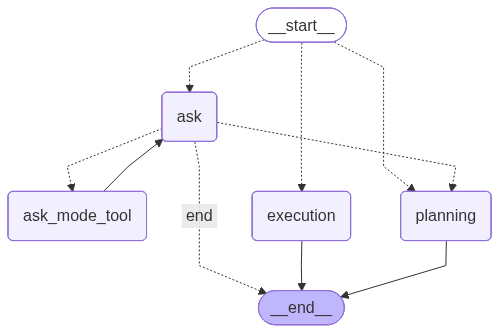

In [13]:
agent

In [31]:
msg = "Think 4 times and explain the unexpected benefits of colonial regimes"
printer.user(msg)
response = agent.invoke({"messages": [HumanMessage(msg)]})

USER  

Think 4 times and explain the unexpected benefits of colonial regimes

                                                                                     Routing from start to ask

                                                                                       ask_node: normal return

                                                                             Routing from ask to ask_mode_tool

                                                                                       ask_node: normal return

                                                                             Routing from ask to ask_mode_tool

                                                                                       ask_node: normal return

                                                                                       Routing from ask to end

In [32]:
response


{
    'messages': [
        HumanMessage(
            content='Think 4 times and explain the unexpected benefits of colonial regimes',
            additional_kwargs={},
            response_metadata={},
            id='655fbfc0-aa5a-4430-899b-c781c4ad46c6'
        ),
        AIMessage(
            content='',
            additional_kwargs={},
            response_metadata={
                'finish_reason': 'tool_calls',
                'model_name': 'Qwen/Qwen3-30B-A3B-Instruct-2507',
                'model_provider': 'openai'
            },
            id='lc_run--019c40dd-6c79-7f83-aa90-6df19f265edb',
            tool_calls=[
                {
                    'name': 'think_tool',
                    'args': {
                        'reflection': 'The query asks for the unexpected benefits of colonial regimes, which is a complex historical and ethical topic. I need to assess whether this falls within my current scope as a general-purpose Q&A agent assisting with a literature su

In [18]:
msg = "How are you?"
printer.user(msg)
all_msgs = []
all_tokens = []
for chunk in agent.stream(
    {"messages": [HumanMessage(msg)]},
    stream_mode="updates",
):
    for step, data in chunk.items():
        messages = data.get("messages", [])
        for m in messages:
            if isinstance(m, AIMessage):
                # Tool calls interrupt streaming
                if m.tool_calls:
                    printer._ensure_stream_closed()
                    for t in m.tool_calls:
                        printer.tool(t["name"], status="running", args=t["args"])
                # Sometimes final structured content arrives here
                # (only print if not already streamed token-wise)
                if m.content and not m.tool_calls:
                    # Only print if stream wasn't used
                    if not printer._ai_stream_active:
                        printer.ai(m.content)
                # Usage metadata normally arrives here
                if m.usage_metadata:
                    printer._ensure_stream_closed()
                    printer.token_usage(
                        m.usage_metadata.get("input_tokens", 0),
                        m.usage_metadata.get("output_tokens", 0),
                        latency=0,
                    )
            elif isinstance(m, ToolMessage):
                printer.tool(
                    m.name,
                    status="finished",
                )

USER  

How are you?

                                                                                     Routing from start to ask

                                                                                       ask_node: normal return

                                                                                       Routing from ask to end